In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import numpy as np                # Numpy for array manipulation for ease of access
import torch                      # Pytorch for array manipulation on the GPU and nice deep learning functions
import torch.nn as nn
import torch.nn.functional as functional
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import cv2
# Image import and display libraries                       # OpenCV for image processing
import matplotlib.pyplot as plt   # Plotting functions
%matplotlib inline

# Image processing libraries for image feature extractor
from scipy.stats import kurtosis, skew
from scipy.ndimage.filters import generic_filter
from skimage.filters import laplace, gabor
from skimage.filters.rank import entropy
from skimage.morphology import disk
from sklearn.preprocessing import scale

# A few more tools
from sklearn import svm           # SVM classifier library
import os                         # Navigate through directories
import csv                        # Read in a CSV file
import time                       # Timing function
import pickle                     # Saving and loading variables

# Mount Google Drive folder as a local folder
# Note: This mounts your entire drive, not the current folder
# from google.colab import drive
# drive.mount('/mydrive')

import kagglehub

# Download latest version
path = kagglehub.dataset_download("newslab/cholecseg8k")

print("Path to dataset files:", path)

batch_size = 10

use_gpu = False
if torch.cuda.is_available(): #use gpu if available
  use_gpu = True
  print("using cuda")

device = torch.device("cuda" if use_gpu else "cpu")


<ipython-input-1-030fb50cac13>:19: DeprecationWarning: Please import `generic_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import generic_filter


100%|██████████| 2.89G/2.89G [00:17<00:00, 174MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/newslab/cholecseg8k/versions/11
using cuda


In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch
import numpy as np

TOOL_PIXEL_VALUE = 32

class CholecSeg8kDataset(Dataset):
    def __init__(self,
                 root_folder: str,
                 image_suffix='_endo.png',
                 mask_suffix='_endo_watershed_mask.png',
                 image_transforms=None,
                 mask_transforms=None,
                 recursive=True,
                 pair_transforms=None,
                 ):
        self.root_folder = root_folder
        self.image_suffix = image_suffix
        self.mask_suffix = mask_suffix
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms
        self.pair_transforms = pair_transforms

        self.image_paths = []
        self.mask_paths = []

        if recursive:
            for root, dirs, files in os.walk(self.root_folder):
                img_files = [f for f in files if f.endswith(self.image_suffix)]
                for img in img_files:
                    base_name = img.replace(self.image_suffix, '')
                    mask_name = base_name + self.mask_suffix

                    if mask_name in files:
                        img_path = os.path.join(root, img)
                        mask_path = os.path.join(root, mask_name)

                        # Check if this mask contains the tool
                        if True or self._mask_has_tool(mask_path):
                            self.image_paths.append(img_path)
                            self.mask_paths.append(mask_path)
        else:
            files = os.listdir(self.root_folder)
            img_files = [f for f in files if f.endswith(self.image_suffix)]
            for img in img_files:
                base_name = img.replace(self.image_suffix, '')
                mask_name = base_name + self.mask_suffix

                if mask_name in files:
                    img_path = os.path.join(self.root_folder, img)
                    mask_path = os.path.join(self.root_folder, mask_name)

                    # Check if this mask contains the tool
                    if True or self._mask_has_tool(mask_path):
                        self.image_paths.append(img_path)
                        self.mask_paths.append(mask_path)

        # Sort to keep consistent ordering
        self.image_paths.sort()
        self.mask_paths.sort()

        if len(self.image_paths) == 0:
            raise RuntimeError("No image-mask pairs found that contain the tool. Check your paths and mask criteria.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        original_mask = np.array(Image.open(mask_path).convert('L'))
        # print(np.unique(original_mask))

        image = np.array(Image.open(image_path).convert('RGB'), dtype=np.float32) / 255.0
        mask = np.array(Image.open(mask_path).convert('L'), dtype=np.uint8)

        mask_binary = (mask == TOOL_PIXEL_VALUE).astype(np.uint8)

        # print(np.unique(mask_binary))
        image_pil = Image.fromarray((image * 255).astype(np.uint8))
        mask_pil = Image.fromarray(mask_binary)

        if self.pair_transforms is not None:
          image_pil, mask_pil = self.pair_transforms(image_pil, mask_pil)

        # Apply image transforms
        if self.image_transforms is not None:
            # Note: The transform pipeline expects PIL or tensor, so we reconvert to PIL if needed.
            image = self.image_transforms(image_pil)
        else:
            image = T.ToTensor()(image)

        # Apply mask transforms
        if self.mask_transforms is not None:

            mask_transformed = self.mask_transforms(mask_pil)
            # mask_transformed = .long()
            # Ensure mask is long and [H,W]
            # print(np.unique(mask_transformed))
            # mask = (mask_transformed > 0.0001).squeeze(0).long()
            mask = (mask_transformed > 0.0001).long()

        else:
            mask = torch.from_numpy(mask_binary).long()

        # mask = mask.unsqueeze(0)

        # print(torch.unique(mask))
        return image, mask

    def _mask_has_tool(self, mask_path):
        mask = np.array(Image.open(mask_path).convert('L'))
        return np.any(mask == TOOL_PIXEL_VALUE)

In [ ]:
size = (272, 480)
import torch
from tqdm import tqdm  # For progress bar

def calculate_mean_std(dataset):
    mean = torch.zeros(3)  # Assuming 3 channels (RGB)
    std = torch.zeros(3)
    num_pixels = 0

    for image, _ in tqdm(dataset):
        # Convert to torch.Tensor if needed
        if not isinstance(image, torch.Tensor):
            image = T.ToTensor()(image)

        # Reshape to (3, H*W)
        image = image.view(3, -1)

        # Update mean and std
        mean += image.mean(dim=1)
        std += image.std(dim=1)
        num_pixels += 1

    # Average over all images
    mean /= num_pixels
    std /= num_pixels

    return mean.tolist(), std.tolist()

# Example: Calculate on training dataset
train_transforms_no_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST)
])

train_dataset_no_norm = CholecSeg8kDataset(
    root_folder=path,
    image_suffix='_endo.png',
    mask_suffix='_endo_watershed_mask.png',
    image_transforms=train_transforms_no_norm,
    mask_transforms=None  # No transforms for mask needed here
)

train_loader_no_norm = DataLoader(train_dataset_no_norm, batch_size=1, shuffle=False)

# Compute mean and std
mean, std = calculate_mean_std(train_loader_no_norm)
print("Calculated Mean:", mean)
print("Calculated Std:", std)


100%|██████████| 8080/8080 [04:30<00:00, 29.84it/s]

Calculated Mean: [0.3369501233100891, 0.21264800429344177, 0.1817651391029358]
Calculated Std: [0.2777565121650696, 0.21871203184127808, 0.18528889119625092]


In [ ]:
import random
import torchvision.transforms.functional as F

class RandomRotationPair:
    """Apply the same random rotation to both image and mask."""
    def __init__(self, degrees):
        self.degrees = degrees

    def __call__(self, image, mask):
        # Randomly pick an angle
        angle = random.uniform(-self.degrees, self.degrees)

        # Rotate image and mask by the same angle
        image = F.rotate(image, angle, interpolation=F.InterpolationMode.BILINEAR)
        mask = F.rotate(mask, angle, interpolation=F.InterpolationMode.NEAREST)

        return image, mask


In [ ]:

from torchvision.transforms import v2
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]

# Define train transforms
train_image_transforms = transforms.Compose([
    transforms.ToTensor(),
    # v2.GaussianNoise(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Normalize(mean=mean, std=std)
])

train_gt_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST)
])

val_image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Normalize(mean=mean, std=std)
])

val_gt_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST)
])

test_image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Normalize(mean=mean, std=std)
])

test_gt_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST)
])

pair_transformations = RandomRotationPair(degrees=10)

full_dataset = CholecSeg8kDataset(
    root_folder = path,
    image_suffix='_endo.png',
    mask_suffix='_endo_watershed_mask.png',
    image_transforms=train_image_transforms,
    mask_transforms=train_gt_transforms,
    pair_transforms=pair_transformations
)

train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

val_dataset.dataset.image_transforms = val_image_transforms
val_dataset.dataset.mask_transforms = val_gt_transforms

test_dataset.dataset.image_transforms = test_image_transforms
test_dataset.dataset.mask_transforms = test_gt_transforms

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


testing the dataloader

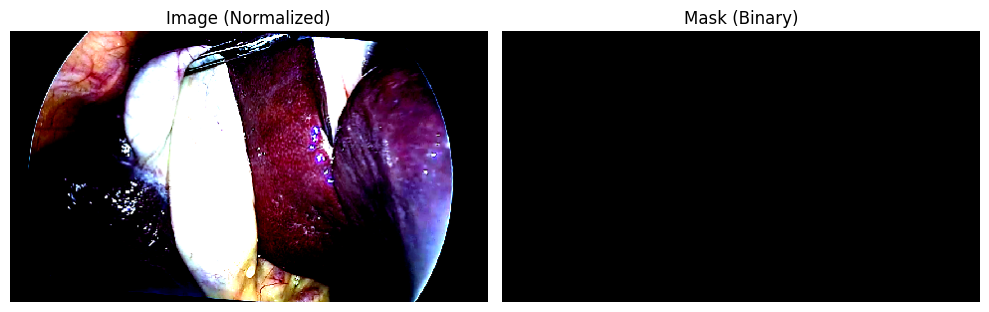

In [ ]:
import matplotlib.pyplot as plt

image, mask = full_dataset[123]

# Convert image (C x H x W) to H x W x C
image_np = image.permute(1, 2, 0).cpu().numpy()
mask_np = mask.squeeze(0).cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_np)
axes[0].set_title('Image (Normalized)')
axes[0].axis('off')

axes[1].imshow(mask_np, cmap='gray')
axes[1].set_title('Mask (Binary)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((enc4, dec4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((enc3, dec3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((enc2, dec2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((enc1, dec1), dim=1)
        dec1 = self.decoder1(dec1)

        final_conv = self.final_conv(dec1)
        return final_conv



In [ ]:
def DICE(model, test_dataloader, smooth=1e-10, isdeeplab=False):
    dice = []
    model.eval()
    for data in test_dataloader:
        img, target = data
        if use_gpu:
            img = img.cuda()
            target = target.cuda()
        out = model(img)['out'] if isdeeplab else model(img)
        predict = out > 0.5
        num = 2 * (predict * target).sum()
        denum = predict.sum() + target.sum()
        dice.append(((num + smooth) / (denum + smooth)).item())
    m_dice = np.mean(dice)
    return m_dice

def DICELoss(scores, target):
    A = scores.view(scores.size (0), -1)
    B = target.view(target.size(0), -1)

    DSC_num = 2 * (A * B).sum(dim=1)
    DSC_den = A.sum(dim=1) + B.sum(dim=1)
    DSC = (DSC_num / DSC_den).mean()

    return 1 - DSC




In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataloader, device, num_samples=5, isdeeplab=False):
    """
    Visualizes predictions by overlaying them on the original images.
    """
    model.eval()
    samples = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            out = model(images)['out'] if isdeeplab else model(images)
            outputs = torch.sigmoid(out)  # Apply sigmoid to get probabilities
            preds = (outputs > 0.5).float()  # Threshold to get binary mask

            # Move tensors to CPU for visualization
            images = images.cpu().numpy()
            masks = masks.cpu().numpy()
            preds = preds.cpu().numpy()

            for i in range(images.shape[0]):
                if samples >= num_samples:
                    return

                fig, axes = plt.subplots(1, 3, figsize=(12, 4))

                # Original Image
                axes[0].imshow(images[i].transpose(1, 2, 0))  # Convert CHW to HWC
                axes[0].set_title("Original Image")
                axes[0].axis('off')

                # Ground Truth Mask
                axes[1].imshow(masks[i].squeeze(), cmap='gray')
                axes[1].set_title("Ground Truth Mask")
                axes[1].axis('off')

                # Predicted Mask
                axes[2].imshow(preds[i].squeeze(), cmap='gray')
                axes[2].set_title("Predicted Mask")
                axes[2].axis('off')

                plt.tight_layout()
                plt.show()

                samples += 1


In [ ]:
def validate(model, dataloader, criterion, device, isdeeplab=False):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)['out'] if isdeeplab else model(images)
            loss = criterion(outputs, masks.float())
            val_loss += loss.item()
    return val_loss / len(dataloader)

def train_loop(model, num_epochs, train_dataloader, val_dataloader, optimizer, criterion, device, save_model_name, isdeeplab=False):
  best_val_loss = float('inf')
  train_losses, val_losses = [], []
  for epoch in range(num_epochs):
      model.train()
      train_loss = 0.0

      for images, masks in train_dataloader:
          images, masks = images.to(device), masks.to(device)

          optimizer.zero_grad()
          outputs = model(images)['out'] if isdeeplab else model(images)
          loss = criterion(outputs, masks.float())
          loss.backward()
          optimizer.step()

          train_loss += loss.item()
      train_loss = train_loss / len(train_dataloader)

      val_loss = validate(model, val_dataloader, criterion, device, isdeeplab=isdeeplab)

      train_losses.append(train_loss)
      val_losses.append(val_loss)

      print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

      # Save the best model
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          torch.save(model.state_dict(), f'{save_model_name}.pth')
          print("Saved best model.")

  return model, train_losses, val_losses

In [ ]:
unet = UNet(in_channels=3, out_channels=1)
learning_rate = 0.001
num_epochs = 10
optimizer_unet = torch.optim.Adam(unet.parameters(), lr=learning_rate)
criterion_unet = nn.BCEWithLogitsLoss()
unet.to(device)
save_model_name_unet = 'best_unet_model_BCE'

In [ ]:
unet, train_losses_unet, val_losses_unet = train_loop(unet, num_epochs, train_dataloader, val_dataloader, optimizer_unet, criterion_unet, device, save_model_name_unet, False)

Epoch 1/15, Train Loss: 0.3707, Val Loss: 0.0393
Saved best model.
Epoch 2/15, Train Loss: 0.0318, Val Loss: 0.0191
Saved best model.
Epoch 3/15, Train Loss: 0.0195, Val Loss: 0.0150
Saved best model.
Epoch 4/15, Train Loss: 0.0136, Val Loss: 0.0208
Epoch 5/15, Train Loss: 0.0196, Val Loss: 0.0242
Epoch 6/15, Train Loss: 0.0151, Val Loss: 0.0100
Saved best model.
Epoch 7/15, Train Loss: 0.0148, Val Loss: 0.0111
Epoch 8/15, Train Loss: 0.0109, Val Loss: 0.0094
Saved best model.
Epoch 9/15, Train Loss: 0.0102, Val Loss: 0.0115
Epoch 10/15, Train Loss: 0.0123, Val Loss: 0.0096
Epoch 11/15, Train Loss: 0.0106, Val Loss: 0.1757
Epoch 12/15, Train Loss: 0.0966, Val Loss: 0.0538
Epoch 13/15, Train Loss: 0.0395, Val Loss: 0.0221
Epoch 14/15, Train Loss: 0.0206, Val Loss: 0.0161
Epoch 15/15, Train Loss: 0.0161, Val Loss: 0.0119


In [ ]:
def test(model, dataloader, device, isdeeplab=False):
    model.eval()
    iou_scores = []
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            out = model(images)['out'] if isdeeplab else model(images)
            outputs = torch.sigmoid(out)
            preds = (outputs > 0.5).float()

            intersection = (preds * masks).sum(dim=(1, 2, 3))
            union = (preds + masks).sum(dim=(1, 2, 3)) - intersection
            iou = intersection / (union + 1e-6)
            iou_scores.append(iou.mean().item())
    return np.mean(iou_scores)

<ipython-input-16-03a7ca541958>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet.load_state_dict(torch.load(save_model_name_unet + '.pth'))


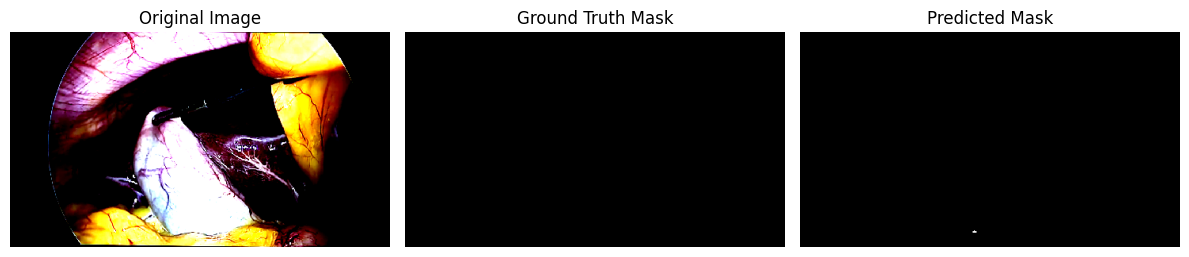

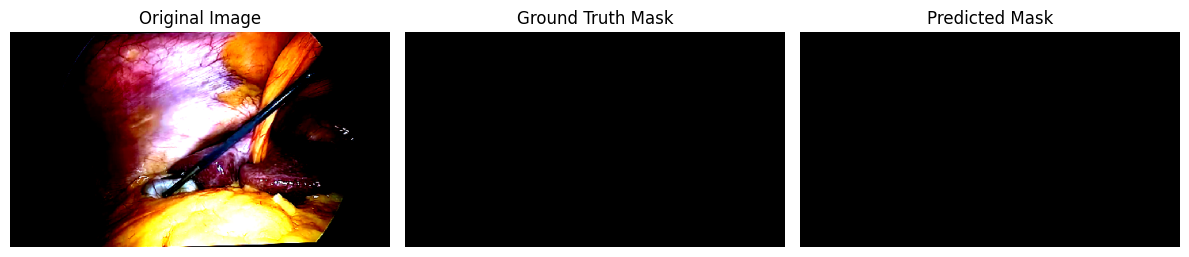

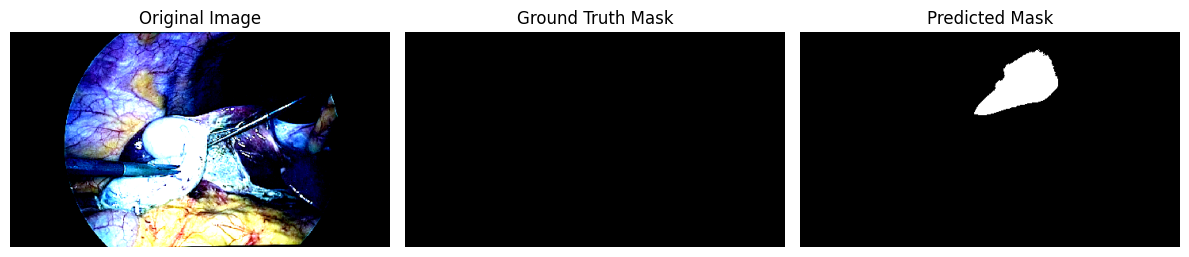

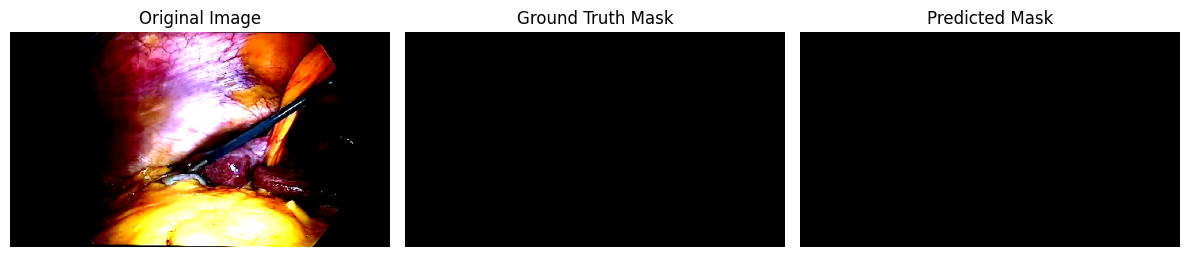

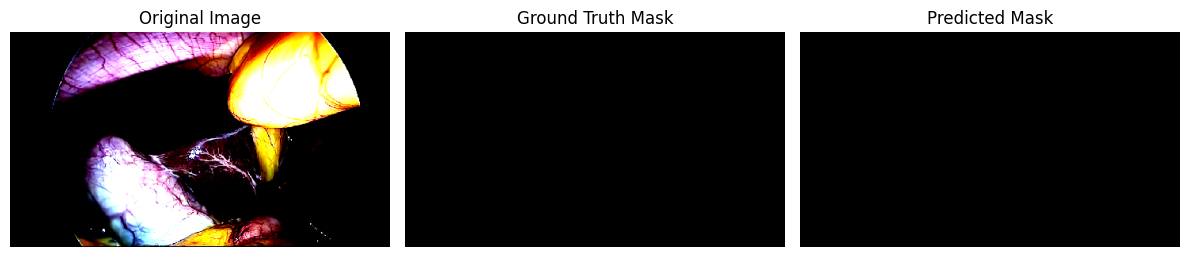

In [ ]:
unet.load_state_dict(torch.load(save_model_name_unet + '.pth'))
visualize_predictions(unet, test_dataloader, device, num_samples=5)

In [ ]:
test_iou_unet = test(unet, test_dataloader, device)
print(f"Test IOU (unet): {test_iou_unet}")
test_dice_unet = DICE(unet, test_dataloader)
print(f"Test DICE (unet): {test_dice_unet}")

Test IOU (unet): 0.23640078901875727
Test DICE (unet): 0.6765522175283176


# DeepLabV3 Attempt

In [ ]:
from torchvision import models


deeplab = models.segmentation.deeplabv3_resnet50(pretrained=True)
deeplab.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)
deeplab.aux_classifier[4] = nn.Conv2d(256, 1, kernel_size=1)
device = torch.device("cuda" if use_gpu else "cpu")
deeplab.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 208MB/s]


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
num_epochs = 15
optimizer_deeplab = torch.optim.Adam(deeplab.parameters(), lr=0.001)
criterion_deeplab = nn.BCEWithLogitsLoss()
save_model_name_deeplab = 'best_deeplab_model_aug3_no_noise'

In [ ]:
deeplab, train_losses_deeplab, val_losses_deeplab = train_loop(deeplab, num_epochs, train_dataloader, val_dataloader, optimizer_deeplab, criterion_deeplab, device, save_model_name_deeplab, isdeeplab=True)

Epoch 1/15, Train Loss: 0.0734, Val Loss: 0.0210
Saved best model.
Epoch 2/15, Train Loss: 0.0150, Val Loss: 0.0131
Saved best model.
Epoch 3/15, Train Loss: 0.0105, Val Loss: 0.0126
Saved best model.
Epoch 4/15, Train Loss: 0.0093, Val Loss: 0.0102
Saved best model.
Epoch 5/15, Train Loss: 0.0106, Val Loss: 0.0734
Epoch 6/15, Train Loss: 0.0112, Val Loss: 0.0140
Epoch 7/15, Train Loss: 0.0089, Val Loss: 0.0098
Saved best model.
Epoch 8/15, Train Loss: 0.0081, Val Loss: 0.0097
Saved best model.
Epoch 9/15, Train Loss: 0.0081, Val Loss: 0.0095
Saved best model.
Epoch 10/15, Train Loss: 0.0080, Val Loss: 0.0093
Saved best model.
Epoch 11/15, Train Loss: 0.0079, Val Loss: 0.0085
Saved best model.
Epoch 12/15, Train Loss: 0.0100, Val Loss: 0.0092
Epoch 13/15, Train Loss: 0.0081, Val Loss: 0.0087
Epoch 14/15, Train Loss: 0.0077, Val Loss: 0.0083
Saved best model.
Epoch 15/15, Train Loss: 0.0089, Val Loss: 0.0106


<ipython-input-15-24e318978f3c>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  deeplab.load_state_dict(torch.load(save_model_name_deeplab + '.pth'))


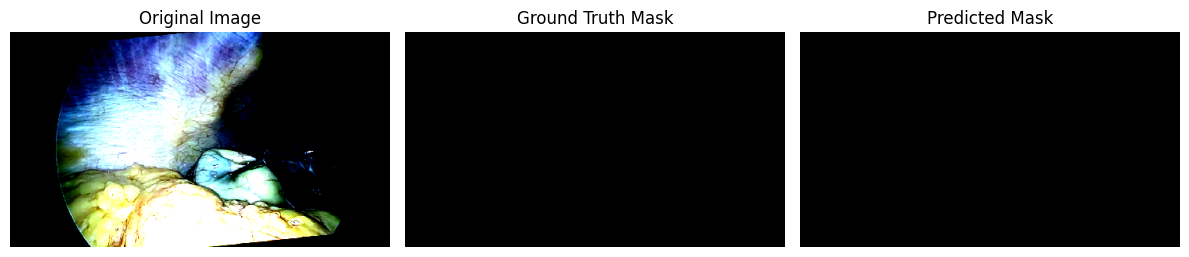

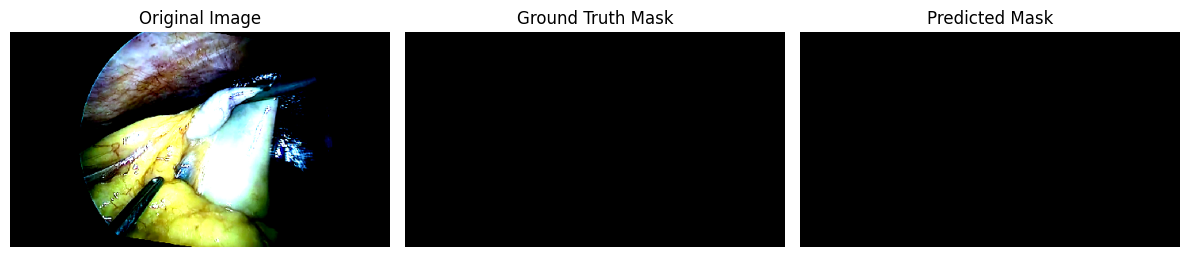

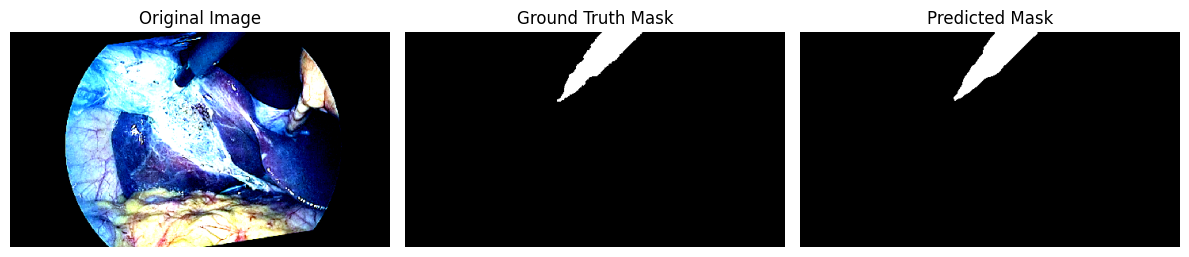

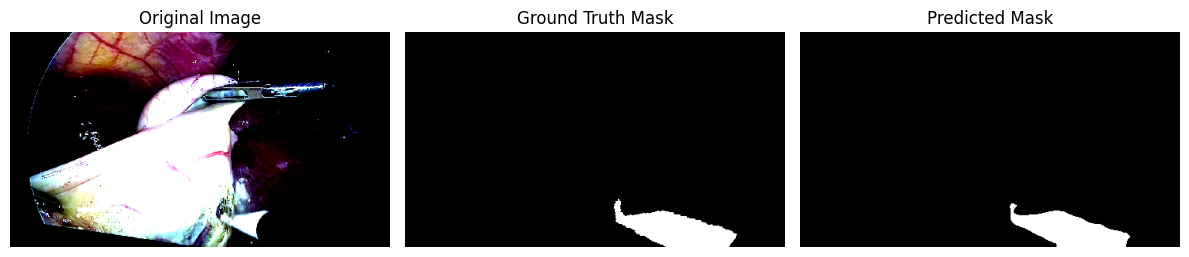

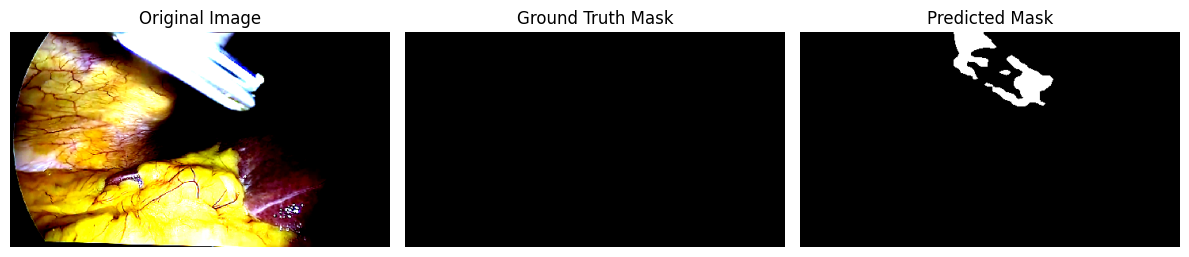

In [ ]:
deeplab.load_state_dict(torch.load(save_model_name_deeplab + '.pth'))
visualize_predictions(deeplab, test_dataloader, device, num_samples=5, isdeeplab=True)

In [ ]:
test_iou_deeplab = test(deeplab, test_dataloader, device, isdeeplab=True)
print(f"Test IOU (DeepLabV3): {test_iou_deeplab}")

test_dice_deeplab = DICE(deeplab, test_dataloader, isdeeplab=True)
print(f"Test DICE (DeepLabV3): {test_dice_deeplab}")

Test IOU (DeepLabV3): 0.24761388672165352
Test DICE (DeepLabV3): 0.8708966872339015


# DeepLabV3Plus Attempt

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet101
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

class DeepLabV3Plus(nn.Module):
    def __init__(self, num_classes, pretrained_backbone=True):
        super(DeepLabV3Plus, self).__init__()

        # Load a ResNet-101 backbone
        backbone = resnet101(pretrained=pretrained_backbone, replace_stride_with_dilation=[False, True, True])
        # Remove the fully connected layer and avgpool
        backbone = nn.Sequential(*list(backbone.children())[:-2])

        # backbone structure:
        # backbone[0] = conv1
        # backbone[1] = bn1
        # backbone[2] = relu
        # backbone[3] = maxpool
        # backbone[4] = layer1 (low-level)
        # backbone[5] = layer2
        # backbone[6] = layer3
        # backbone[7] = layer4

        self.backbone = backbone
        # ASPP + final classification head (without decoder)
        self.aspp = DeepLabHead(2048, 256)  # This creates an ASPP module + final conv that outputs 256 features

        self.low_level_projection = nn.Sequential(
            nn.Conv2d(256, 48, kernel_size=1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )

        # Decoder
        self.final_conv = nn.Sequential(
            nn.Conv2d(304, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, num_classes, kernel_size=1, stride=1)
        )

    def forward(self, x):
        input_size = x.shape[-2:]

        # Extract features
        x = self.backbone[0:4](x)       # Stem: conv1, bn1, relu, maxpool
        low_level_features = self.backbone[4](x)  # layer1 output
        x = self.backbone[5](low_level_features)   # layer2
        x = self.backbone[6](x)                    # layer3
        x = self.backbone[7](x)                    # layer4

        # ASPP
        high_level_features = self.aspp(x)  # shape: N, 256, H/16, W/16 (for example)

        # Low-level projection
        low_level_features = self.low_level_projection(low_level_features)  # shape: N, 48, H/4, W/4

        # Upsample the high-level features to match the low-level spatial size
        high_level_features = nn.functional.interpolate(
            high_level_features,
            size=low_level_features.shape[-2:],
            mode='bilinear', align_corners=False
        )

        # Concatenate and decode
        concatenated = torch.cat([low_level_features, high_level_features], dim=1) # N, 304, H/4, W/4
        output = self.final_conv(concatenated) # N, num_classes, H/4, W/4

        # Upsample to input size
        output = nn.functional.interpolate(output, size=input_size, mode='bilinear', align_corners=False)

        return output

In [ ]:
deeplab_plus = DeepLabV3Plus(1)
device = torch.device("cuda" if use_gpu else "cpu")
deeplab_plus.to(device)

DeepLabV3Plus(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv

In [ ]:
num_epochs = 15
optimizer_deeplab_plus = torch.optim.Adam(deeplab.parameters(), lr=learning_rate)
criterion_deeplab_plus = nn.BCEWithLogitsLoss()
save_model_name_deeplab_plus = 'best_deeplab_plus_model'

In [ ]:
deeplab_plus, train_losses_deeplab_plus, val_losses_deeplab_plus = train_loop(deeplab_plus, num_epochs, train_dataloader, val_dataloader, optimizer_deeplab_plus, criterion_deeplab_plus, device, save_model_name_deeplab_plus)

Epoch 1/15, Train Loss: 0.7698, Val Loss: 0.7679
Saved best model.
Epoch 2/15, Train Loss: 0.7700, Val Loss: 0.7743
Epoch 3/15, Train Loss: 0.7700, Val Loss: 0.7727
Epoch 4/15, Train Loss: 0.7698, Val Loss: 0.7722
Epoch 5/15, Train Loss: 0.7699, Val Loss: 0.7726
Epoch 6/15, Train Loss: 0.7700, Val Loss: 0.7722


KeyboardInterrupt: 

<ipython-input-64-287750ca4236>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  deeplab_plus.load_state_dict(torch.load(save_model_name_deeplab_plus + '.pth'))


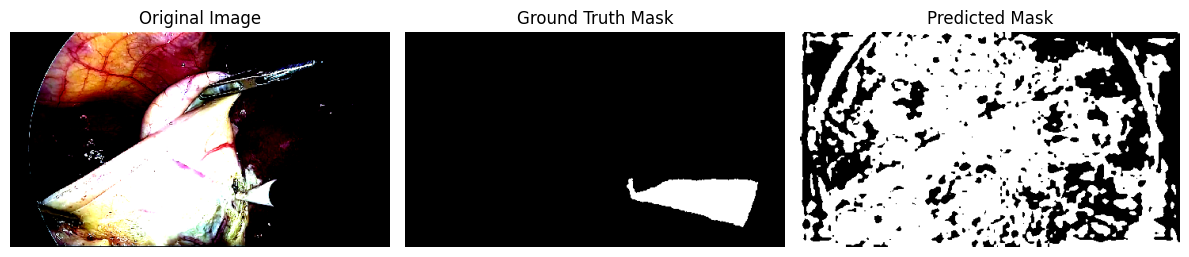

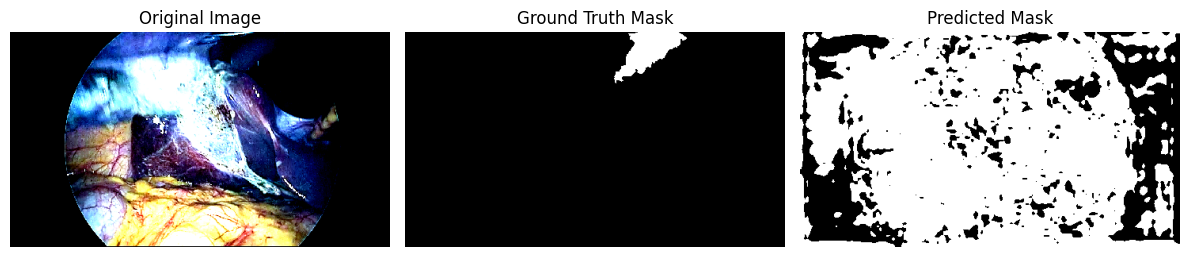

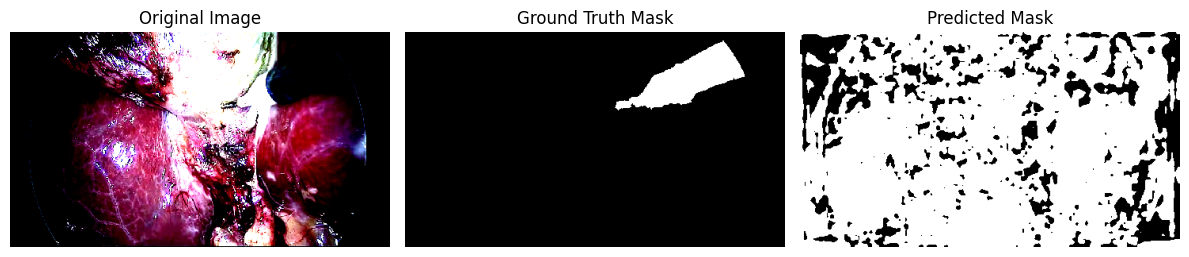

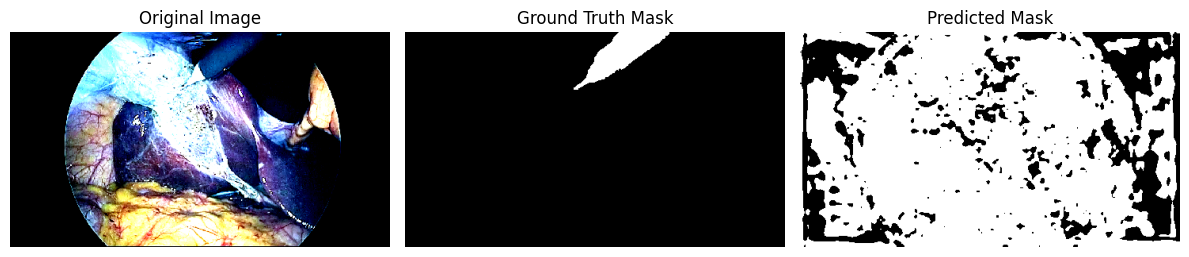

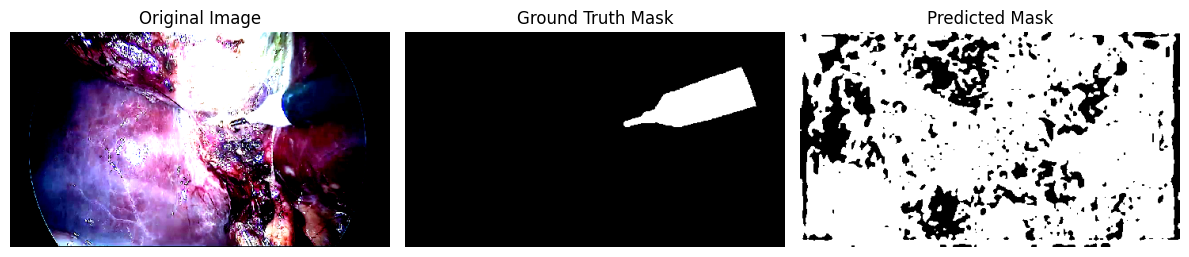

In [ ]:
deeplab_plus.load_state_dict(torch.load(save_model_name_deeplab_plus + '.pth'))
visualize_predictions(deeplab_plus, test_dataloader, device, num_samples=5)

In [ ]:
test_iou_deeplab_plus = test(deeplab_plus, test_dataloader, device)
print(f"Test IOU (DeepLabV3Plus): {test_iou_deeplab_plus}")
test_dice_deeplab_plus = DICE(deeplab_plus, test_dataloader)
print(f"Test DICE (DeepLabV3Plus): {test_dice_deeplab_plus}")

Test IOU (DeepLabV3Plus): 0.04887125183456264
Test DICE (DeepLabV3Plus): 0.10142394700484263


In [ ]:
from torchvision import models
import torch
import torch.nn as nn

# Load the pre-trained model
deeplab = models.segmentation.deeplabv3_resnet50(pretrained=True)

# Modify the classifier and auxiliary classifier for transfer learning
deeplab.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)
deeplab.aux_classifier[4] = nn.Conv2d(256, 1, kernel_size=1)

# Freeze all layers except the first and last
for name, param in deeplab.named_parameters():
    # Unfreeze the first and last layers based on their names
    if not ("backbone.conv1" in name or "classifier.4" in name or "aux_classifier.4" in name):
        param.requires_grad = False

# Check that the correct layers are frozen
for name, param in deeplab.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deeplab.to(device)



In [ ]:
from torchvision import models
import torch
import torch.nn as nn

# Load the pre-trained model
deeplab = models.segmentation.deeplabv3_resnet50(pretrained=True)

# Modify the classifier and auxiliary classifier for transfer learning
deeplab.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)
deeplab.aux_classifier[4] = nn.Conv2d(256, 1, kernel_size=1)

# Freeze all layers except the first and last
for name, param in deeplab.named_parameters():
    # Unfreeze the first and last layers based on their names
    if not ("backbone.conv1" in name or "classifier.4" in name or "aux_classifier.4" in name):
        param.requires_grad = False

# Check that the correct layers are frozen
for name, param in deeplab.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deeplab.to(device)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 170MB/s]


backbone.conv1.weight: requires_grad=True
backbone.bn1.weight: requires_grad=False
backbone.bn1.bias: requires_grad=False
backbone.layer1.0.conv1.weight: requires_grad=False
backbone.layer1.0.bn1.weight: requires_grad=False
backbone.layer1.0.bn1.bias: requires_grad=False
backbone.layer1.0.conv2.weight: requires_grad=False
backbone.layer1.0.bn2.weight: requires_grad=False
backbone.layer1.0.bn2.bias: requires_grad=False
backbone.layer1.0.conv3.weight: requires_grad=False
backbone.layer1.0.bn3.weight: requires_grad=False
backbone.layer1.0.bn3.bias: requires_grad=False
backbone.layer1.0.downsample.0.weight: requires_grad=False
backbone.layer1.0.downsample.1.weight: requires_grad=False
backbone.layer1.0.downsample.1.bias: requires_grad=False
backbone.layer1.1.conv1.weight: requires_grad=False
backbone.layer1.1.bn1.weight: requires_grad=False
backbone.layer1.1.bn1.bias: requires_grad=False
backbone.layer1.1.conv2.weight: requires_grad=False
backbone.layer1.1.bn2.weight: requires_grad=False
b

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
num_epochs = 15
optimizer_deeplab = torch.optim.Adam(deeplab.parameters(), lr=0.001)
criterion_deeplab = nn.BCEWithLogitsLoss()
save_model_name_deeplab = 'best_deeplab_model2'

In [ ]:
deeplab, train_losses_deeplab, val_losses_deeplab = train_loop(deeplab, num_epochs, train_dataloader, val_dataloader, optimizer_deeplab, criterion_deeplab, device, save_model_name_deeplab, isdeeplab=True)

Epoch 1/15, Train Loss: 0.2042, Val Loss: 0.1646
Saved best model.
Epoch 2/15, Train Loss: 0.1440, Val Loss: 0.1496
Saved best model.
Epoch 3/15, Train Loss: 0.1189, Val Loss: 0.1584
Epoch 4/15, Train Loss: 0.1034, Val Loss: 0.1021
Saved best model.
Epoch 5/15, Train Loss: 0.0926, Val Loss: 0.1013
Saved best model.
Epoch 6/15, Train Loss: 0.0873, Val Loss: 0.0951
Saved best model.
Epoch 7/15, Train Loss: 0.0813, Val Loss: 0.0916
Saved best model.
Epoch 8/15, Train Loss: 0.0755, Val Loss: 0.0790
Saved best model.
Epoch 9/15, Train Loss: 0.0731, Val Loss: 0.0807
Epoch 10/15, Train Loss: 0.0696, Val Loss: 0.0824
Epoch 11/15, Train Loss: 0.0673, Val Loss: 0.0879
Epoch 12/15, Train Loss: 0.0642, Val Loss: 0.0651
Saved best model.
Epoch 13/15, Train Loss: 0.0634, Val Loss: 0.0794
Epoch 14/15, Train Loss: 0.0598, Val Loss: 0.0691
Epoch 15/15, Train Loss: 0.0583, Val Loss: 0.0709


<ipython-input-13-24e318978f3c>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  deeplab.load_state_dict(torch.load(save_model_name_deeplab + '.pth'))


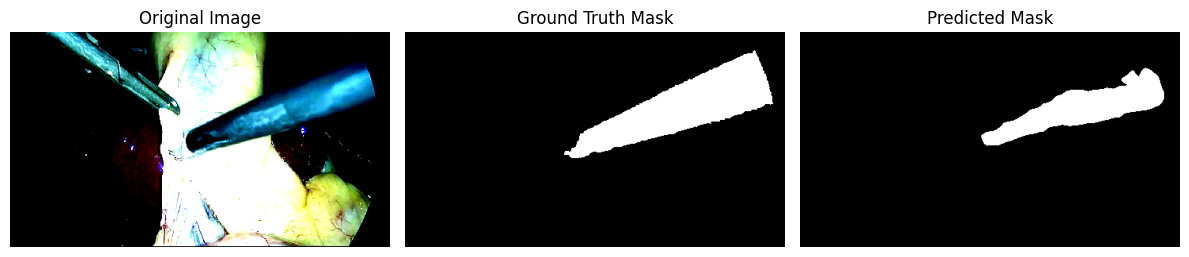

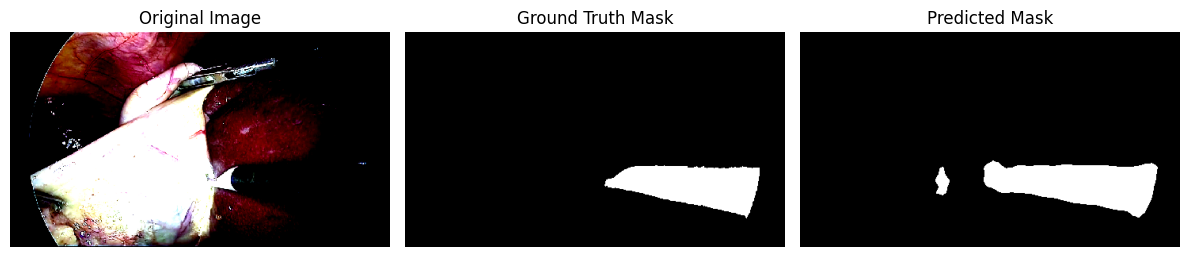

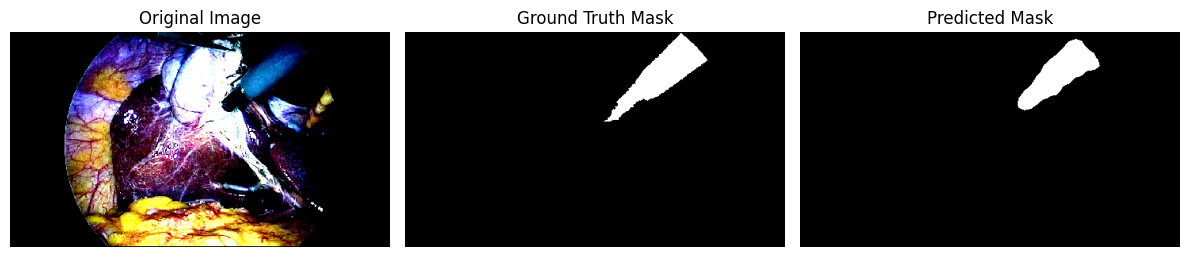

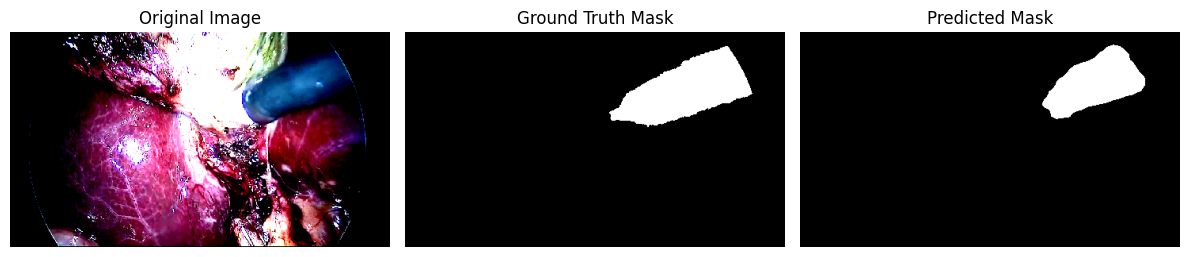

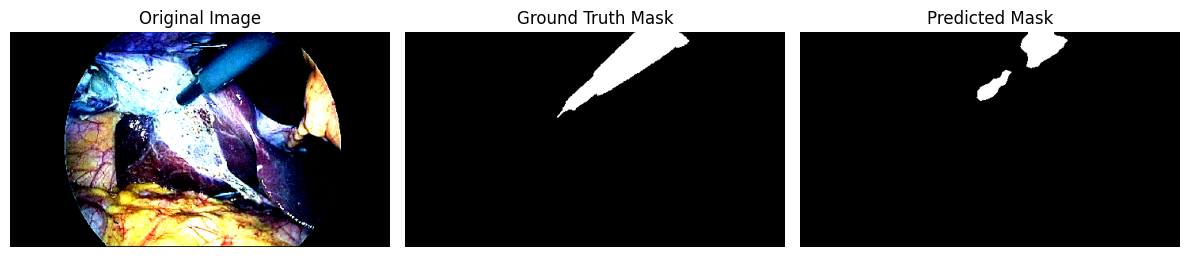

In [ ]:
deeplab.load_state_dict(torch.load(save_model_name_deeplab + '.pth'))
visualize_predictions(deeplab, test_dataloader, device, num_samples=5, isdeeplab=True)

In [ ]:
test_iou_deeplab = test(deeplab, test_dataloader, device, isdeeplab=True)
print(f"Test IOU (DeepLabV3): {test_iou_deeplab}")

test_dice_deeplab = DICE(deeplab, test_dataloader, isdeeplab=True)
print(f"Test DICE (DeepLabV3): {test_dice_deeplab}")

Test IOU (DeepLabV3): 0.4702092110488689
Test DICE (DeepLabV3): 0.5168797669219676
